In [3]:
#Box 1: Setting up and running the SRIM calculation

import os

import numpy as np
import matplotlib.pyplot as plt

from srim import TRIM, Ion, Layer, Target
from srim.output import Results




# Construct an ion, energy in eV
ion = Ion('H', energy=20.0e6) #I will get the upper limit for energy from Adam

# Construct a layer, displacement energy of in eV, density in gcm^-3
layer = Layer({
        'Fe': {
            'stoich': 68.995,
            'E_d': 40.0,
            'lattice': 0.0,
            'surface': 3.0
        },
        'C':{'stoich': 0.080,
            'E_d': 40.0,
            'lattice': 0.0,
            'surface': 3.0
        },
        'Mn':{'stoich': 2.000,
            'E_d': 40.0,
            'lattice': 0.0,
            'surface': 3.0
        },
        'P':{'stoich': 0.045,
            'E_d': 40.0,
            'lattice': 0.0,
            'surface': 3.0
        },
        'S':{'stoich': 0.030,
            'E_d': 40.0,
            'lattice': 0.0,
            'surface': 3.0
        },
        'Si':{'stoich': 0.750,
            'E_d': 40.0,
            'lattice': 0.0,
            'surface': 3.0
        },
        'Cr':{'stoich': 19.000,
            'E_d': 40.0,
            'lattice': 0.0,
            'surface': 3.0
        },
        'Ni':{'stoich': 9.000,
            'E_d': 40.0,
            'lattice': 0.0,
            'surface': 3.0
        },
        'N':{'stoich': 0.100,
            'E_d': 40.0,
            'lattice': 0.0,
            'surface': 3.0
        }}, density=8.0, width=2e7)

# Construct a target of a single layer of Nickel
target = Target([layer])

# Initialize a TRIM calculation
trim = TRIM(target, ion, number_ions=10000, calculation=1) #will be changeg to 99 999 ions when the max energy value will be known

# Specify the directory of SRIM.exe
# For windows users the path will include C://...
srim_executable_directory = 'C:/Users/domin/OneDrive/Desktop/SRIM'

# takes about 10 seconds on my laptop
results = trim.run(srim_executable_directory)
# results is `srim.output.Results` and contains all output files parsed

output_directory = 'C:/Users/domin/OneDrive/Desktop/SRIM/tmp/srim_outputs'
os.makedirs(output_directory, exist_ok=True)
TRIM.copy_output_files('C:/Users/domin/OneDrive/Desktop/SRIM', output_directory)
folders = ['C:/Users/domin/OneDrive/Desktop/SRIM/tmp/srim_outputs']


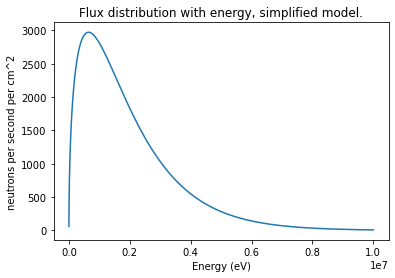

In [77]:
#Box 2: Calculating the required dpa
# assuming fluence of e19 over 40y lifespan and that being cused soley by fission n
import numpy as np

fluence = 1e19 #n/cm^2
time = 40*365.25*24*60*60 #40y in seconds
flux = fluence/time #flux in n/cm^2s
#Maxwell-Boltzmann density function
E_bar=1.935e6
E = np.array(range(100,10000000))
x = (3*np.sqrt((1.5*E)/np.pi)*np.exp(-1.5*E/E_bar))/np.sqrt(E_bar**3)
flux_distribution = flux*x


import matplotlib.pyplot as plt
plt.plot(E,flux_distribution)
plt.ylabel('neutrons per second per cm^2')
plt.xlabel('Energy (eV)')
plt.title('Flux distribution with energy, simplified model.')
plt.show()


#calculating damage energy deposition per atom per second
#calculating the damage energy cross section


In [19]:
#Box 3

from srim import output

def plot_damage_energy(folder, ax):
     results = Results(folder)
     phon = results.phonons # This data contains energy lost to phonons per Angstom per Ion
     dx = max(phon.depth) / 100.0 # To units of Angstroms
     energy_damage = (phon.ions + phon.recoils) * dx # This gives the damage energy in eV (?)
     ax.plot(phon.depth, energy_damage / phon.num_ions, label='{}'.format(folder))
     return sum(energy_damage) # Gives the damage energy imparted to the sample over the entire thickness.
"""
def plot_vacancies(folder, ax):
     results = Results(folder)
     vac = results.vacancy
     vacancy_depth = vac.knock_ons + np.sum(vac.vacancies, axis=1)
     ax.plot(vac.depth, vacancy_depth, label="Total vacancies at depth")
     return sum(vacancy_depth)
"""

Damage energy: 9482.047906000002 eV
55.05143735000001
time in hours to get a dpa of 0.01: 6.153980233888744


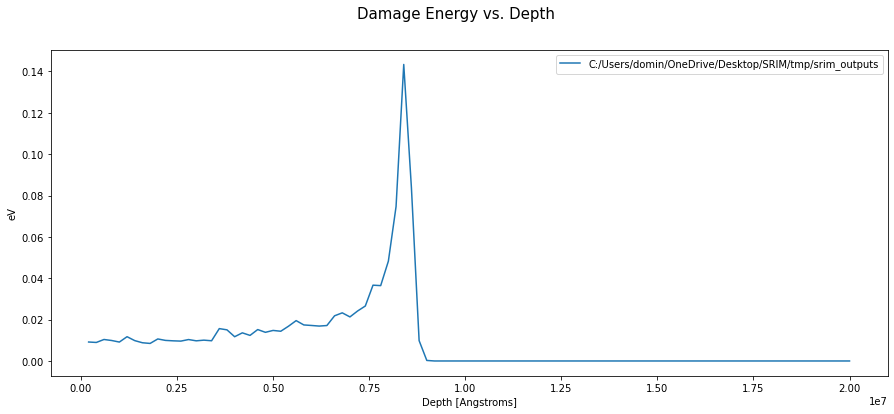

In [73]:
#Box 4: Calculating the irradiation time

# making a plot
fig, axes = plt.subplots(1, len(folders), sharex=True, sharey=True)

for ax, folder in zip(np.ravel(axes), folders):
    energy_damage = plot_damage_energy(folder, ax)
    print("Damage energy: {} eV".format(energy_damage))
    ax.set_xlabel('Depth [Angstroms]')
    ax.set_ylabel('eV')
    ax.legend()


fig.suptitle('Damage Energy vs. Depth', fontsize=15)
fig.set_size_inches((15, 6))

# Getting displacment values
dpi = (0.8 * energy_damage)/(40) # as explained in On th euse of SRIM for computing radiation damage exposure

# to get dpa
mass_density = 8 # g/cm^3
V = 15*15*2/1000 #cm^3, smaple dimensions converted to cm
Avogadro = 6.02e23 # atoms/mol
# molar mass is assumed to be the weighted sum of molar masses of constituents which is probably wrong
molar_mass = (1/100)*(68.995*55.845+0.08*12.011+2*54.938+0.045*30.974+0.03*42.06+0.75*28.085+19*51.996+9*58.693+0.1*14.007)
print(molar_mass)

#calculating the number of atoms
atoms = (mass_density*Avogadro*V)/(molar_mass)

#number of ions used in SRIM
fluence = 10000
dpa = (dpi * fluence)/(atoms)

#run time
required_dpa = 0.01 #going through that above, not done yet
flux = 9.37e13

time = (required_dpa*atoms)/(dpi*flux*3600) #in hours

print('time in hours to get a dpa of {}: {}'.format(required_dpa,time))
